# Single qubit example and algorithm usage

In this notebook we use simulated measurements to show how the mGST algorithm is used. <br>
First we will make sure all the necessary functions are available by running the following python scripts. 

In [1]:
%run ../mGST/additional_fns
%run ../mGST/low_level_jit
%run ../mGST/algorithm
%run ../mGST/compatibility
%run ../mGST/optimization

Next up, let's create a random gate set and define the parameters that we need:

In [2]:
pdim = 2   # physical dimension
r = pdim**2   # rank of the gate superoperators 

l = 8  # maximum number of gates in each measurement sequence
d = 4  # number of gates
rK_true = 1   # rank of simulated gates
rK = 1   # rank of the model estimate
n_povm = 2   # number of POVM-elements

Now we can use some of the functions we imported to generate a random gate set.
The function *randKrausSet_Haar(d,r,rK_true)* generates d sets of Kraus operators, where each set is found by taking a Haar random unitary and using a subset of its columns the generate an isometry of shape (rK_true*pdim) x (pdim). <br>
For the true state and measurement we can simply take a random positive semidefinite matrix.

In [3]:
K_true = randKrausSet_Haar(d,r,rK_true)   # tensor of random Kraus operators
X_true = np.einsum('ijkl,ijnm -> iknlm', K_true, K_true.conj()).reshape(d,r,r)   # tensor of superoperators
rho_true = randpsd(r)   # random initial state
E1 = randpsd(r)   # random POVM element
E_true = np.array([E1, np.eye(pdim).reshape(-1)-E1])   # Full POVM

Next up we need some gate sequence instructions and simulated measurements. Each gate is identified by an index between 0 and d-1, meaning a gate sequences can most simply be represented by a list of gate indices. We write a full set containing *N* many sequence instructions as a numpy array *J* of shape *N* x *d*. The resulting state after each sequences is measured *meas_samples*-times with a POVM consisting of *n_povm* many alements. Therefore we will have *n_povm*-many estimated probabilites per sequences and we can collect all results in a numpy array *y* of shape *n_povm* x *N*. 

In [4]:
N = 100
meas_samples = 1e5
J_rand = np.array(random.sample(range(d**l), N))   # generate random numbers between 0 and $d^l - 1$
J = np.array([local_basis(ind,d,l) for ind in J_rand])   # turn random numbers into gate instructions
y = np.real(np.array([[E_true[i].conj()@contract(X_true,j)@rho_true for j in J] for i in range(n_povm)]))   # obtain ideal output probabilities
y_sampled = sampled_measurements(y,meas_samples).copy()   # simulate finite sampling statistics

For our first test we use an initialitation where the state preparation and measurement are random, but the gate are just rotated versions of the ideal gates. 

In [5]:
delta = 0.5  # unitary noise parameter

# Generate noisy version of true gate set
K0 = np.zeros((d,rK,pdim,pdim)).astype(np.complex128)
for i in range(d):
    U_p = expm(delta*1j*randHerm(pdim)).astype(np.complex128)   # unitary noise
    K0[i] = np.einsum('jkl,lm',K_true[i],U_p)
X0 = np.einsum('ijkl,ijnm -> iknlm', K0, K0.conj()).reshape(d,r,r) 

rho0 = randpsd(r).copy()   # random initial state
A0 = randKrausSet(1,r,n_povm)[0].conj()   # random POVM decomposition
E0 = np.array([(A0[i].T.conj()@A0[i]).reshape(-1) for i in range(n_povm)]).copy()

Now it's time to run mGST on the data set. Note that if the algorithm is run for the first time on a new machine it can take up to a few minutes to compile the low level functions (such as derivatives). <br>
The main function is called *run_mGST*, for information it's variables and outputs we can call the help(run_mGST):

In [ ]:
help(run_mGST)

Initialization successful, improving estimate over full data....
#################
	 Convergence crit. satisfied
	 Final objective function value 2.615105348046682e-06 with # of initializations: 1 
 	 Total runtime: 10.532119035720825
MVE: 0.0005509921532491616


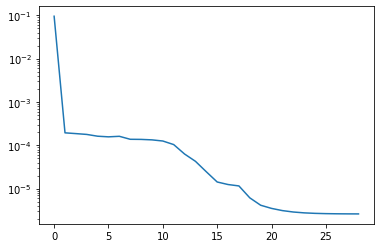

In [6]:
bsize = 50   # The batch size on which the optimization is started
K,X,E,rho,res_list = run_mGST(y_sampled,J,l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                     max_inits = 3, max_iter = 30, final_iter = 10, 
                     target_rel_prec = 1e-4, init = [K0,E0,rho0])
plt.semilogy(res_list)   # plot the objective function over the iterations
print('MVE:', MVE(X_true,E_true,rho_true,X,E,rho,d,l, n_povm)[0])   # output the final mean variation error

## XYI gate set $\{\mathrm{Id}, e^{i \frac{\alpha}{2} \sigma_y}, e^{i \frac{\alpha}{2} \sigma_x}\}$ from random initialization
The XYI gate set is a minimal gate set that is tomographically complete when applied to the $|0><0|$ state and constitutes a standard example for gate set tomography. In this example we don't give an initialization to mGST, resulting in a random initialization to be generated automatically. As a result, more than one initialization attempt might be necessary to converge to a satisfying objective funtion value. We can tweak the number of allowerd initializations with the *max_inits* parameter.

In [10]:
from pygsti.modelpacks import smq1Q_XYI as std
mdl_datagen = std.target_model().depolarize(0.01).randomize_with_unitary(0.01)   # use pygsti-function to add noise
X_true, E_true, rho_true = pygsti_model_to_arrays(mdl_datagen, basis = 'std')   # turn pygsti model object into numpy arrays

pdim = 2
r = pdim**2

l = 7
d = 3

n_povm = 2 
rK = 2

In [11]:
sequence_count = 100
meas_samples = 1e5
J_rand = np.array(random.sample(range(d**l), sequence_count))
J = np.array([local_basis(ind,d,l) for ind in J_rand])
y = np.real(np.array([[E_true[i].conj()@contract(X_true,j)@rho_true for j in J] for i in range(n_povm)]))
y_sampled = sampled_measurements(y,meas_samples).copy()

Run  0 failed, trying new initialization...
Initialization successful, improving estimate over full data....
#################
	 Convergence crit. satisfied
	 Final objective function value 4.138231355917263e-06 with # of initializations: 2 
 	 Total runtime: 112.615487575531
MVE: (0.001810443561951306, 0.009914306144880463)


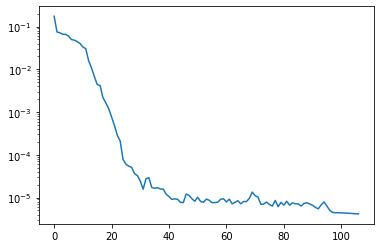

In [12]:
%run ../mGST/algorithm
bsize = 50
t0 = time.time()
K,X,E,rho,res_list = run_mGST(y_sampled,J,l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                     max_inits = 5, max_iter = 100, final_iter = 10, 
                     target_rel_prec = 1e-4)
plt.semilogy(res_list)
print('MVE:', MVE(X_true,E_true,rho_true,X,E,rho,d,l, n_povm))